# Data Processing 

## Jade Benson

In this notebook, I combine data from the three separate dataframes (weather, ACS, and falls) to create a final cleaned dataframe used in all subsequent analysis and visualization. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import mapclassify as mc

# Part 1 

## Data Preparation

### Load in Falls Counts

In [2]:
monthly_falls = pd.read_csv("medicare_monthly_falls.csv")

In [3]:
monthly_falls.head()

,month_count,fipscounty,date
0,NaN,1001,2010-01
1,14.0,1001,2011-01
2,NaN,1001,2012-01
3,NaN,1001,2013-01
4,NaN,1001,2014-01


In [4]:
monthly_falls.describe()

,month_count,fipscounty
count,72081.000000,205544.000000
mean,46.854636,30494.034114
std,71.720914,15060.357268
min,11.000000,1001.000000
25%,15.000000,19017.000000
50%,23.000000,29141.000000
75%,47.000000,45057.000000
max,1319.000000,56045.000000


In [76]:
#how many falls? 
monthly_falls['month_count'].sum()

3377329.0

In [5]:
len(monthly_falls['fipscounty'].unique())

3107

In [78]:
raw_falls_no_missing = monthly_falls[~monthly_falls['month_count'].isna()]

In [82]:
len(raw_falls_no_missing)

72081

In [79]:
#number of total falls (no missing)
raw_falls_no_missing['month_count'].sum()

3377329.0

In [81]:
#number of unique counties with no missing falls 
len(raw_falls_no_missing['fipscounty'].unique())

1790

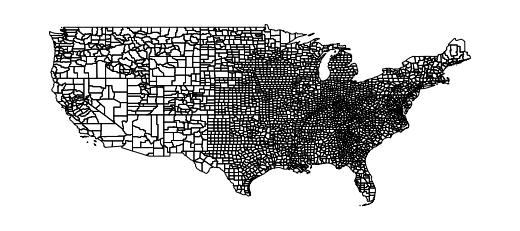

In [6]:
# plotting 
#https://python-graph-gallery.com/choropleth-map-geopandas-python

# Load the json file with county coordinates
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

# Remove Alaska, Hawaii and Puerto Rico.
stateToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(stateToRemove)]

US_maps = geoData.to_csv('US_map_boundaries.csv')

# Basic plot with just county outlinesb
gplt.polyplot(geoData, figsize=(20, 4));

In [7]:
def grouped_county_df(df):
    """
    Groups number of falls by county, multiple index
    """
    #reset index and drop duplicates
    grouped_df = df.set_index(['fipscounty', 'date'], inplace=False)
    unique_month_falls = grouped_df[~grouped_df.index.duplicated(keep='first')]
    return unique_month_falls

In [8]:
grouped_falls = grouped_county_df(monthly_falls)

In [9]:
#monthly fall counts for each county
grouped_falls.head()

month_count
fipscounty date                
1001       2010-01          NaN
           2011-01         14.0
           2012-01          NaN
           2013-01          NaN
           2014-01          NaN

In [12]:
print("Total records (with NAs): ", len(grouped_falls))
print("Total nonmissing falls : ", len(grouped_falls[~grouped_falls['month_count'].isna()]))
print("Percentage non-missing : ", len(grouped_falls[~grouped_falls['month_count'].isna()]) / len(grouped_falls))

Total records (with NAs):  205471
Total nonmissing falls :  72008
Percentage non-missing :  0.350453348647741


In [13]:
#summary statistics of fall counts
grouped_falls.describe()

,month_count
count,72008.000000
mean,46.868056
std,71.755419
min,11.000000
25%,15.000000
50%,23.000000
75%,47.000000
max,1319.000000


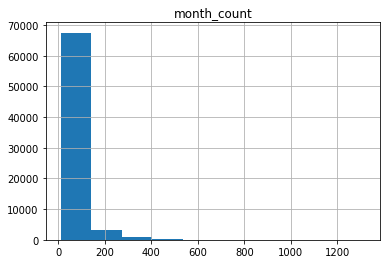

In [14]:
grouped_falls.hist();

In [15]:
grouped_falls[grouped_falls['month_count']==1319]
#the max fall count is in Cook county (Chicago) in Jan 2013

,,month_count
fipscounty,date,
17031,2013-01,1319.0


In [266]:
#high fall counts (over 200)
high_falls = grouped_falls[grouped_falls['month_count']>200]
len(high_falls)

2428

In [16]:
def plot_fall_counts(grouped_df, var_name, US_map, title): 
    """
    Plots the grouped_df on a US_map from GeoData
    """
    total_month_counts = grouped_df.groupby(['fipscounty']).sum()
    plot_data = US_map.merge(total_month_counts, left_on=['id'], right_on=['fipscounty'])
    
    
    #plot 
    # Initialize the figure
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))

    # Set up the color sheme:
    scheme = mc.Quantiles(plot_data[var_name], k=10)

    # Map
    gplt.choropleth(plot_data, 
        hue=var_name, 
        linewidth=.1,
        scheme=scheme, cmap='Greens',
        legend=True,
        edgecolor='black',
        ax=ax
    );

    ax.set_title(title, fontsize=13);

    

/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/jadebenson/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 7
  Warn("Warning: setting k to %d" % k_q, UserWarning)


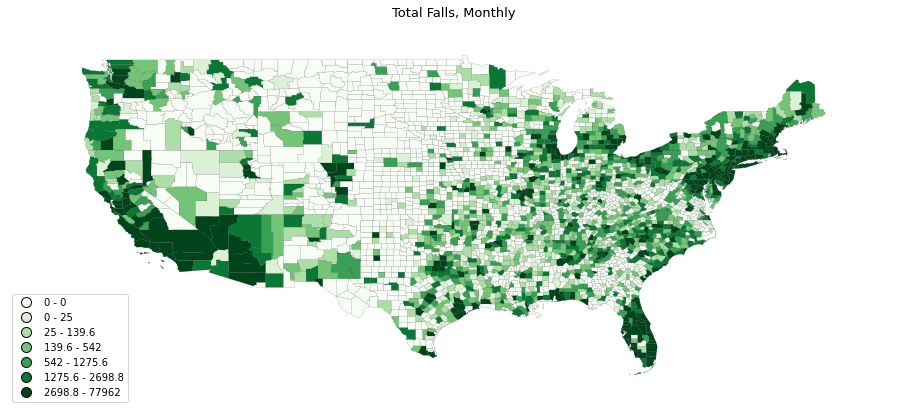

In [50]:
#total fall count by county
plot_fall_counts(grouped_falls, 'month_count', geoData, "Total Falls, Monthly")

### Load in Weather

In [18]:
weather = pd.read_pickle('monthly_weather_summary.pkl')

In [19]:
weather.head()

,FIPS,month_year,tavg_min,tavg_max,tavg_median,tavg_mean,tavg_std,tmin_min,tmin_max,tmin_median,...,pres_min,pres_max,pres_median,pres_mean,pres_std,tsun_min,tsun_max,tsun_median,tsun_mean,tsun_std
0,1001,2009-07,23.0,28.7,26.4,26.306897,1.427018,16.2,24.5,22.0,...,1008.7,1022.0,1016.30,1016.054167,2.961342,NaN,NaN,NaN,NaN,NaN
1,1001,2009-08,21.9,28.6,26.2,26.096552,1.591604,15.8,24.1,22.7,...,1012.2,1021.6,1016.85,1017.096429,2.036788,NaN,NaN,NaN,NaN,NaN
2,1001,2009-09,17.4,26.4,24.6,24.158621,2.024408,11.2,23.1,22.0,...,1011.9,1018.8,1016.75,1015.935714,2.193292,NaN,NaN,NaN,NaN,NaN
3,1001,2009-10,8.9,26.5,19.3,18.162069,4.860586,3.8,22.1,14.7,...,1008.3,1025.8,1015.85,1016.707143,4.409244,NaN,NaN,NaN,NaN,NaN
4,1001,2009-11,6.7,18.1,12.2,12.196552,2.732278,0.9,16.0,6.5,...,1011.7,1026.8,1019.90,1019.275000,3.990881,NaN,NaN,NaN,NaN,NaN


In [20]:
#this includes all the monthly variables created from the weather processing daily notebook
weather.columns

Index(['FIPS', 'month_year', 'tavg_min', 'tavg_max', 'tavg_median',
       'tavg_mean', 'tavg_std', 'tmin_min', 'tmin_max', 'tmin_median',
       'tmin_mean', 'tmin_std', 'tmax_min', 'tmax_max', 'tmax_median',
       'tmax_mean', 'tmax_std', 'prcp_min', 'prcp_max', 'prcp_median',
       'prcp_mean', 'prcp_std', 'snow_min', 'snow_max', 'snow_median',
       'snow_mean', 'snow_std', 'wdir_min', 'wdir_max', 'wdir_median',
       'wdir_mean', 'wdir_std', 'wspd_min', 'wspd_max', 'wspd_median',
       'wspd_mean', 'wspd_std', 'wpgt_min', 'wpgt_max', 'wpgt_median',
       'wpgt_mean', 'wpgt_std', 'pres_min', 'pres_max', 'pres_median',
       'pres_mean', 'pres_std', 'tsun_min', 'tsun_max', 'tsun_median',
       'tsun_mean', 'tsun_std'],
      dtype='object')

### Load in ACS - Sociodemographic variables 

In [21]:
#ACS data - still in long format 
acs = pd.read_csv('final_ACS_vars.csv', index_col = 0)


In [22]:
acs.head()

,GEOID,total_pop,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor
1,1001,3828,26728.0,0.4100,7321,0.091381,0.577244,0.829531,0.067614
2,1003,10881,25349.0,0.4517,33782,0.104790,0.536025,0.928453,0.065449
3,1005,3138,16750.0,0.4608,4180,0.112440,0.569139,0.652392,0.150239
4,1007,1687,19545.0,0.4365,3209,0.101901,0.550016,0.831100,0.109691
5,1009,5106,23858.0,0.4134,9172,0.087767,0.554514,0.960423,0.092673


In [23]:
len(acs)

3220

In [24]:
unique_acs = acs.drop_duplicates()
len(unique_acs)

3220

In [25]:
acs.describe()

,GEOID,total_pop,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor
count,3220.000000,3220.000000,3142.000000,3220.000000,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000
mean,31393.643478,8117.627019,23957.480586,0.441816,1.359009e+04,0.127555,0.551010,0.851034,0.107975
std,16292.019724,22619.093279,5179.583618,0.036075,3.876406e+04,0.036522,0.030220,0.204148,0.069089
min,1001.000000,22.000000,8090.000000,0.334600,6.000000e+00,0.000000,0.306931,0.000000,0.000000
25%,19032.500000,1427.000000,20603.000000,0.418100,1.962750e+03,0.104194,0.537529,0.804453,0.069999
50%,30024.000000,2751.500000,23322.000000,0.438700,4.209000e+03,0.125251,0.554277,0.936753,0.090627
75%,46107.500000,6737.250000,26464.250000,0.463500,1.030650e+04,0.148176,0.568248,0.975539,0.123280
max,72153.000000,751076.000000,59876.000000,0.651900,1.149893e+06,0.395833,1.000000,1.000000,0.593927


In [26]:
#merge this with ACS to get the censusarea 
county_area = geoData[['id', 'CENSUSAREA']]
county_area.head()

,id,CENSUSAREA
0,1001,594.436
1,1009,644.776
2,1017,596.531
3,1021,692.854
4,1033,592.619


In [27]:
acs_full = acs.merge(county_area, left_on = 'GEOID', right_on = 'id', how = 'inner')

In [28]:
acs_full.head()

,GEOID,total_pop,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,id,CENSUSAREA
0,1001,3828,26728.0,0.4100,7321,0.091381,0.577244,0.829531,0.067614,1001,594.436
1,1003,10881,25349.0,0.4517,33782,0.104790,0.536025,0.928453,0.065449,1003,1589.784
2,1005,3138,16750.0,0.4608,4180,0.112440,0.569139,0.652392,0.150239,1005,884.876
3,1007,1687,19545.0,0.4365,3209,0.101901,0.550016,0.831100,0.109691,1007,622.582
4,1009,5106,23858.0,0.4134,9172,0.087767,0.554514,0.960423,0.092673,1009,644.776


In [29]:
acs_full['pop_density'] = acs_full['total_pop'] / acs_full['CENSUSAREA']

## Merging

In [30]:
monthly_falls['month_year'] = pd.to_datetime(monthly_falls['date']).dt.to_period('M')

In [31]:
falls_weather = monthly_falls.merge(weather, left_on = ['fipscounty', 'month_year'], right_on = ['FIPS', 'month_year'], how = 'inner')

In [32]:
len(falls_weather['fipscounty'].unique())

3105

In [33]:
falls_weather.head()

,month_count,fipscounty,date,month_year,FIPS,tavg_min,tavg_max,tavg_median,tavg_mean,tavg_std,...,pres_min,pres_max,pres_median,pres_mean,pres_std,tsun_min,tsun_max,tsun_median,tsun_mean,tsun_std
0,NaN,1001,2010-01,2010-01,1001,-3.9,15.6,6.70,5.393103,6.070769,...,1002.2,1033.8,1023.00,1020.110345,8.091192,NaN,NaN,NaN,NaN,NaN
1,14.0,1001,2011-01,2011-01,1001,-2.3,16.1,6.70,5.823333,4.301217,...,1004.6,1034.2,1018.95,1019.213333,6.671594,NaN,NaN,NaN,NaN,NaN
2,NaN,1001,2012-01,2012-01,1001,0.3,18.9,11.75,11.310714,5.214747,...,1006.0,1031.5,1020.40,1020.540741,6.408664,NaN,NaN,NaN,NaN,NaN
3,NaN,1001,2013-01,2013-01,1001,5.0,20.9,12.40,12.092308,5.250137,...,1008.4,1030.9,1023.80,1022.432000,5.037751,NaN,NaN,NaN,NaN,NaN
4,NaN,1001,2014-01,2014-01,1001,-7.2,11.6,3.90,3.485185,4.998669,...,1015.2,1035.5,1021.40,1022.922727,6.570130,NaN,NaN,NaN,NaN,NaN


In [34]:
len(falls_weather['month_count'])

195568

In [37]:
full_df = falls_weather.merge(acs_full, left_on = 'FIPS', right_on = 'GEOID', how = 'inner')

In [38]:
full_df.head()

,month_count,fipscounty,date,month_year,FIPS,tavg_min,tavg_max,tavg_median,tavg_mean,tavg_std,...,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,id,CENSUSAREA,pop_density
0,NaN,1001,2010-01,2010-01,1001,-3.9,15.6,6.70,5.393103,6.070769,...,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,1001,594.436,6.439718
1,14.0,1001,2011-01,2011-01,1001,-2.3,16.1,6.70,5.823333,4.301217,...,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,1001,594.436,6.439718
2,NaN,1001,2012-01,2012-01,1001,0.3,18.9,11.75,11.310714,5.214747,...,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,1001,594.436,6.439718
3,NaN,1001,2013-01,2013-01,1001,5.0,20.9,12.40,12.092308,5.250137,...,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,1001,594.436,6.439718
4,NaN,1001,2014-01,2014-01,1001,-7.2,11.6,3.90,3.485185,4.998669,...,26728.0,0.41,7321,0.091381,0.577244,0.829531,0.067614,1001,594.436,6.439718


In [39]:
#number of unique counties
len(full_df['fipscounty'].unique())

3104

In [40]:
#number of months
len(full_df['date'].unique())

73

In [41]:
#raw fall rate 
full_df['raw_fall_rate'] = full_df['month_count'] / full_df['pop_65_up']

In [42]:
#scaled fall rate (per 100,000 adults 65 years and older)
full_df['scaled_fall_rate'] = full_df['raw_fall_rate'] * 100000

In [43]:
full_df.iloc[70:100, :]

,month_count,fipscounty,date,month_year,FIPS,tavg_min,tavg_max,tavg_median,tavg_mean,tavg_std,...,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,id,CENSUSAREA,pop_density,raw_fall_rate,scaled_fall_rate
70,NaN,1001,2012-12,2012-12,1001,3.3,18.7,13.70,12.132143,4.720566,...,7321,0.091381,0.577244,0.829531,0.067614,1001,594.436,6.439718,NaN,NaN
71,NaN,1001,2013-12,2013-12,1001,2.6,22.3,7.85,10.657692,5.951079,...,7321,0.091381,0.577244,0.829531,0.067614,1001,594.436,6.439718,NaN,NaN
72,NaN,1001,2014-12,2014-12,1001,5.8,18.1,9.70,10.792308,3.997792,...,7321,0.091381,0.577244,0.829531,0.067614,1001,594.436,6.439718,NaN,NaN
73,36.0,1003,2010-01,2010-01,1003,-0.5,19.1,8.70,8.083333,6.103860,...,33782,0.104790,0.536025,0.928453,0.065449,1003,1589.784,6.844326,0.001066,106.565627
74,35.0,1003,2011-01,2011-01,1003,0.8,18.8,10.15,9.317857,4.458288,...,33782,0.104790,0.536025,0.928453,0.065449,1003,1589.784,6.844326,0.001036,103.605470
75,37.0,1003,2012-01,2012-01,1003,4.3,21.5,15.00,14.634615,5.279465,...,33782,0.104790,0.536025,0.928453,0.065449,1003,1589.784,6.844326,0.001095,109.525783
76,47.0,1003,2013-01,2013-01,1003,7.8,22.9,15.00,14.865385,4.786476,...,33782,0.104790,0.536025,0.928453,0.065449,1003,1589.784,6.844326,0.001391,139.127346
77,41.0,1003,2015-01,2015-01,1003,-2.3,20.3,8.85,8.950000,4.579471,...,33782,0.104790,0.536025,0.928453,0.065449,1003,1589.784,6.844326,0.001214,121.366408
78,26.0,1003,2010-02,2010-02,1003,3.7,15.4,8.45,8.391667,3.222194,...,33782,0.104790,0.536025,0.928453,0.065449,1003,1589.784,6.844326,0.000770,76.964064
79,33.0,1003,2011-02,2011-02,1003,3.7,23.0,11.50,12.634783,6.625818,...,33782,0.104790,0.536025,0.928453,0.065449,1003,1589.784,6.844326,0.000977,97.685158


In [44]:
#want to include regions in this dataframe too, include even those counties missing fall data for mapping 
full_df_regions = full_df.merge(geoData, left_on=['fipscounty'], right_on=['id'], how ='outer')


In [45]:
#https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
#regions key 
west_codes = ['53', '41', '06', '30', '16', '56', '32', '49', '08', '04', '35']
midwest_codes = ['38', '46', '31', '20', '27', '19', '29', '55', '17', '18', '26', '39']
south_codes = ['48', '40', '05', '22', '28', '01', '13', '12', '45', '37', '21', '47', '54','24', '10', '51', '11']
northeast_codes = ['42', '36', '34', '50', '33', '23', '09', '44', '25']

In [47]:
full_df_regions['region'] = np.where(full_df_regions['STATE'].isin(west_codes), 'west',
                               np.where(full_df_regions['STATE'].isin(midwest_codes), 'midwest',
                                        np.where(full_df_regions['STATE'].isin(south_codes), 'south',
                                                 np.where(full_df_regions['STATE'].isin(northeast_codes), 'northeast',0
                              ))))

In [51]:
full_df_regions.columns

Index(['month_count', 'fipscounty', 'date', 'month_year', 'FIPS', 'tavg_min',
       'tavg_max', 'tavg_median', 'tavg_mean', 'tavg_std', 'tmin_min',
       'tmin_max', 'tmin_median', 'tmin_mean', 'tmin_std', 'tmax_min',
       'tmax_max', 'tmax_median', 'tmax_mean', 'tmax_std', 'prcp_min',
       'prcp_max', 'prcp_median', 'prcp_mean', 'prcp_std', 'snow_min',
       'snow_max', 'snow_median', 'snow_mean', 'snow_std', 'wdir_min',
       'wdir_max', 'wdir_median', 'wdir_mean', 'wdir_std', 'wspd_min',
       'wspd_max', 'wspd_median', 'wspd_mean', 'wspd_std', 'wpgt_min',
       'wpgt_max', 'wpgt_median', 'wpgt_mean', 'wpgt_std', 'pres_min',
       'pres_max', 'pres_median', 'pres_mean', 'pres_std', 'tsun_min',
       'tsun_max', 'tsun_median', 'tsun_mean', 'tsun_std', 'GEOID',
       'total_pop', 'median_income', 'gini_index', 'pop_65_up',
       'prop_65_85_up', 'prop_female', 'prop_white_nh', 'prop_poor', 'id_x',
       'CENSUSAREA_x', 'pop_density', 'raw_fall_rate', 'scaled_fall_rate',

In [53]:
full_df_regions.drop(['FIPS', 'month_year', 'GEOID', 'total_pop', 'id_x', 'CENSUSAREA_y', 'id_y', 'COUNTY', 'NAME', 'LSAD', 'raw_fall_rate'], axis = 1, inplace = True)

In [57]:
full_df_regions.to_pickle("full_data_regions.pkl")

In [274]:
#save to csv too for R 
full_df_regions.to_csv("full_data_regions.csv")

In [58]:
#how many observations? This also includes those that are missing counties and falls 
#since outer merge
len(full_df_regions)

195500

In [60]:
full_df_regions.isnull().sum()

month_count         126272
fipscounty               5
date                     5
tavg_min              6338
tavg_max              6338
                     ...  
scaled_fall_rate    126272
GEO_ID                   0
STATE                    0
geometry                 0
region                   0
Length: 67, dtype: int64

In [61]:
#remove the wdir, wdgt, pressure tsun variables since so much missingness
full_df_regions.drop(["wdir_min", "wdir_max", "wdir_median", "wdir_mean", "wdir_std",
                                                    "wpgt_min", "wpgt_max", "wpgt_median", "wpgt_mean", "wpgt_std",
                                                    "pres_min", "pres_max", "pres_median", "pres_mean", "pres_std",
                                                   "tsun_min", "tsun_max", "tsun_median", "tsun_mean", "tsun_std"], axis = 1, inplace = True)

In [62]:
#5 missing counties (see this reoccuring)
full_df_regions.isnull().sum()

month_count         126272
fipscounty               5
date                     5
tavg_min              6338
tavg_max              6338
tavg_median           6338
tavg_mean             6338
tavg_std              7158
tmin_min               139
tmin_max               139
tmin_median            139
tmin_mean              139
tmin_std               951
tmax_min               140
tmax_max               140
tmax_median            140
tmax_mean              140
tmax_std               952
prcp_min             79252
prcp_max             79252
prcp_median          79252
prcp_mean            79252
prcp_std             79712
snow_min            161809
snow_max            161809
snow_median         161809
snow_mean           161809
snow_std            161914
wspd_min              4910
wspd_max              4910
wspd_median           4910
wspd_mean             4910
wspd_std              5797
median_income            5
gini_index               5
pop_65_up                5
prop_65_85_up            5
p

In [63]:
#easy way to deal with the precipitation and snow 
full_df_regions['prcp_min'] = full_df_regions['prcp_min'].replace(np.nan, 0)
full_df_regions['prcp_max'] = full_df_regions['prcp_max'].replace(np.nan, 0)
full_df_regions['prcp_median'] = full_df_regions['prcp_median'].replace(np.nan, 0)
full_df_regions['prcp_mean'] = full_df_regions['prcp_mean'].replace(np.nan, 0)
full_df_regions['prcp_std'] = full_df_regions['prcp_std'].replace(np.nan, 0)

full_df_regions['snow_min'] = full_df_regions['snow_min'].replace(np.nan, 0)
full_df_regions['snow_max'] = full_df_regions['snow_max'].replace(np.nan, 0)
full_df_regions['snow_median'] = full_df_regions['snow_median'].replace(np.nan, 0)
full_df_regions['snow_mean'] = full_df_regions['snow_mean'].replace(np.nan, 0)
full_df_regions['snow_std'] = full_df_regions['snow_std'].replace(np.nan, 0)


In [64]:
full_df_regions.isnull().sum()

month_count         126272
fipscounty               5
date                     5
tavg_min              6338
tavg_max              6338
tavg_median           6338
tavg_mean             6338
tavg_std              7158
tmin_min               139
tmin_max               139
tmin_median            139
tmin_mean              139
tmin_std               951
tmax_min               140
tmax_max               140
tmax_median            140
tmax_mean              140
tmax_std               952
prcp_min                 0
prcp_max                 0
prcp_median              0
prcp_mean                0
prcp_std                 0
snow_min                 0
snow_max                 0
snow_median              0
snow_mean                0
snow_std                 0
wspd_min              4910
wspd_max              4910
wspd_median           4910
wspd_mean             4910
wspd_std              5797
median_income            5
gini_index               5
pop_65_up                5
prop_65_85_up            5
p

In [65]:
#small datasets with more interpretable variables 
small_set = full_df_regions.drop([ 'tavg_min', 'tavg_max', 'tavg_median',  'tavg_std',
        'tmin_max', 'tmin_median', 'tmin_mean', 'tmin_std',
       'tmax_min',  'tmax_median', 'tmax_mean', 'tmax_std',
       'prcp_min', 'prcp_mean', 'prcp_median',  'prcp_std',
       'snow_min',  'snow_median', 'snow_mean', 'snow_std',
       'wspd_min',  'wspd_median', 'wspd_mean', 'wspd_std'], axis = 1, inplace = False)


In [66]:
small_set.isnull().sum()

month_count         126272
fipscounty               5
date                     5
tavg_mean             6338
tmin_min               139
tmax_max               140
prcp_max                 0
snow_max                 0
wspd_max              4910
median_income            5
gini_index               5
pop_65_up                5
prop_65_85_up            5
prop_female              5
prop_white_nh            5
prop_poor                5
CENSUSAREA_x             5
pop_density              5
scaled_fall_rate    126272
GEO_ID                   0
STATE                    0
geometry                 0
region                   0
dtype: int64

In [67]:
#find a better way to deal with the missingness?
#just dropping rows with any missing values 
no_missing_data = small_set.dropna()

In [68]:
no_missing_data.describe()

,month_count,fipscounty,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor,CENSUSAREA_x,pop_density,scaled_fall_rate
count,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,6.694500e+04,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000,66945.000000
mean,46.669729,30428.904369,13.727632,0.697405,27.207233,11.671616,7.761297,21.547019,25936.348480,0.445919,3.726828e+04,0.129568,0.561835,0.859050,0.084612,933.915110,48.366273,157.010741
std,72.292838,15495.299891,9.611165,11.253450,8.295228,27.130052,44.711290,7.351409,5581.851296,0.030795,7.429048e+04,0.023939,0.018228,0.139238,0.030226,1355.901857,151.017829,67.252725
min,11.000000,1001.000000,-19.066667,-37.800000,-13.000000,0.000000,0.000000,0.000000,12861.000000,0.352500,1.008000e+03,0.049210,0.469969,0.047547,0.023863,5.468000,0.133814,1.217505
25%,15.000000,18005.000000,6.590000,-6.600000,22.000000,0.000000,0.000000,16.200000,22123.000000,0.425100,1.022800e+04,0.112735,0.551216,0.807577,0.064569,434.487000,8.296301,114.081643
50%,23.000000,33003.000000,14.927586,0.600000,28.900000,0.500000,0.000000,21.000000,25057.000000,0.444600,1.644500e+04,0.129507,0.563373,0.909124,0.078996,617.140000,17.013867,146.949136
75%,47.000000,42121.000000,21.686667,9.400000,33.300000,17.300000,0.000000,26.200000,28169.000000,0.464900,3.633400e+04,0.146109,0.573519,0.958305,0.097693,888.150000,36.169832,185.597624
max,1319.000000,56033.000000,36.110345,26.700000,49.400000,4790.400000,914.000000,70.200000,59876.000000,0.597500,1.149893e+06,0.238095,0.621529,1.000000,0.339693,20056.938000,3579.175610,1190.476190


In [69]:
#how many monthly fall rates? 
len(no_missing_data)

66945

In [84]:
no_missing_data['month_count'].sum()

3124305.0

In [83]:
#how many unique counties included? 
len(no_missing_data['fipscounty'].unique())

1733

In [71]:
#how many unique months? 
len(no_missing_data['date'].unique())

73

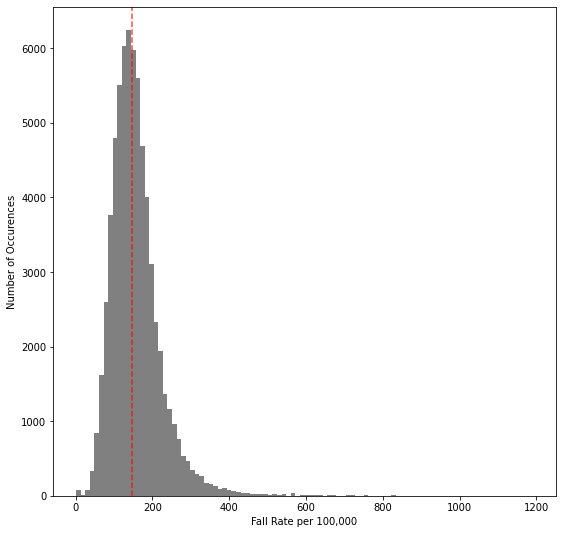

In [263]:
fig, ax = plt.subplots(figsize = (9, 9))
ax.hist(no_missing_data['scaled_fall_rate'], bins = 100, color = 'grey')
#147 is the median value 
ax.axvline(147, linestyle = '--', color = 'red', alpha = 0.7)
#ax.text(150, 6000,'Median: 147 falls per 100,000',rotation=0)
ax.set(xlabel = 'Fall Rate per 100,000', ylabel = 'Number of Occurences')
plt.savefig('falls_hist_median.png');

In [73]:
#what percentage below 200 falls per 100,000? 
len(no_missing_data[no_missing_data['scaled_fall_rate']<=200])/ len(no_missing_data)

0.8130704309507805

In [74]:
#what is the maximum fall rate in the dataset without missing values? 
no_missing_data[no_missing_data['scaled_fall_rate']== max(no_missing_data['scaled_fall_rate'])]

,month_count,fipscounty,date,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,...,prop_female,prop_white_nh,prop_poor,CENSUSAREA_x,pop_density,scaled_fall_rate,GEO_ID,STATE,geometry,region
60537,12.0,20183.0,2014-01,-2.593103,-22.5,18.8,0.0,0.0,34.2,24357.0,...,0.553571,0.985119,0.109127,895.465,1.017349,1190.47619,0500000US20183,20,"POLYGON ((-98.72637 40.00222, -98.72629 40.002...",midwest


In [75]:
no_missing_data.to_pickle("no_missing_data.pkl")

In [275]:
#save to csv too for R 
no_missing_data.to_csv("no_missing_data.csv")

# Part 2 


## Data Exploration

## Look at geospatial variation of cumulative fall rates using analytic sample

In [168]:
#will need to use both the full and the non-missing to show what our analytic sample looks like, but also the missing data

full_df = pd.read_pickle("full_data_regions.pkl")
no_missing = pd.read_pickle("no_missing_data.pkl")

In [169]:
no_missing.head()

,month_count,fipscounty,date,tavg_mean,tmin_min,tmax_max,prcp_max,snow_max,wspd_max,median_income,...,prop_female,prop_white_nh,prop_poor,CENSUSAREA_x,pop_density,scaled_fall_rate,GEO_ID,STATE,geometry,region
1,14.0,1001.0,2011-01,5.823333,-8.0,23.0,0.0,0.0,16.8,26728.0,...,0.577244,0.829531,0.067614,594.436,6.439718,191.230706,0500000US01001,01,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",south
6,12.0,1001.0,2010-02,6.296154,-4.4,21.6,0.0,0.0,16.0,26728.0,...,0.577244,0.829531,0.067614,594.436,6.439718,163.912034,0500000US01001,01,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",south
8,12.0,1001.0,2012-02,12.468966,-4.5,25.6,0.0,0.0,22.2,26728.0,...,0.577244,0.829531,0.067614,594.436,6.439718,163.912034,0500000US01001,01,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",south
9,12.0,1001.0,2013-02,10.213333,-2.3,22.4,0.0,0.0,12.9,26728.0,...,0.577244,0.829531,0.067614,594.436,6.439718,163.912034,0500000US01001,01,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",south
11,12.0,1001.0,2015-02,6.696000,-6.1,20.2,0.0,0.0,19.2,26728.0,...,0.577244,0.829531,0.067614,594.436,6.439718,163.912034,0500000US01001,01,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",south


In [170]:
#group non-missing
fall_rates_grouped = grouped_county_df(no_missing)

In [171]:
fall_rates_grouped.head()

month_count  tavg_mean  tmin_min  tmax_max  prcp_max  \
fipscounty date                                                            
1001.0     2011-01         14.0   5.823333      -8.0      23.0       0.0   
           2010-02         12.0   6.296154      -4.4      21.6       0.0   
           2012-02         12.0  12.468966      -4.5      25.6       0.0   
           2013-02         12.0  10.213333      -2.3      22.4       0.0   
           2015-02         12.0   6.696000      -6.1      20.2       0.0   

                    snow_max  wspd_max  median_income  gini_index  pop_65_up  \
fipscounty date                                                                
1001.0     2011-01       0.0      16.8        26728.0        0.41     7321.0   
           2010-02       0.0      16.0        26728.0        0.41     7321.0   
           2012-02       0.0      22.2        26728.0        0.41     7321.0   
           2013-02       0.0      12.9        26728.0        0.41     7321.0   
           2015-02       0.0      19.2        26728.0        0.41     7321.0   

                    ...  prop_female  prop_white_nh  prop_poor  CENSUSAREA_x  \
fipscounty date     ...                                                        
1001.0     2011-01  ...     0.577244       0.829531   0.067614       594.436   
           2010-02  ...     0.577244       0.829531   0.067614       594.436   
           2012-02  ...     0.577244       0.829531   0.067614       594.436   
           2013-02  ...     0.577244       0.829531   0.067614       594.436   
           2015-02  ...     0.577244       0.829531   0.067614       594.436   

                    pop_density  scaled_fall_rate          GEO_ID STATE  \
fipscounty date                                                           
1001.0     2011-01     6.439718        191.230706  0500000US01001    01   
           2010-02     6.439718        163.912034  0500000US01001    01   
           2012-02     6.439718        163.912034  0500000US01001    01   
           2013-02     6.439718        163.912034  0500000US01001    01   
           2015-02     6.439718        163.912034  0500000US01001    01   

                                                             geometry region  
fipscounty date                                                               
1001.0     2011-01  POLYGON ((-86.49677 32.34444, -86.71790 32.402...  south  
           2010-02  POLYGON ((-86.49677 32.34444, -86.71790 32.402...  south  
           2012-02  POLYGON ((-86.49677 32.34444, -86.71790 32.402...  south  
           2013-02  POLYGON ((-86.49677 32.34444, -86.71790 32.402...  south  
           2015-02  POLYGON ((-86.49677 32.34444, -86.71790 32.402...  south  

[5 rows x 21 columns]

**Now want to sum all the counts of falls, then divide by total population** 

In [172]:
total_county_falls = fall_rates_grouped['month_count'].groupby([ "fipscounty"] ).sum().reset_index()

In [173]:
total_county_falls.head()

,fipscounty,month_count
0,1001.0,299.0
1,1003.0,2438.0
2,1009.0,60.0
3,1013.0,46.0
4,1015.0,2905.0


In [208]:
#now get the population over 65 to create total fall rates 
#now we use the full dataframe to get all counties back and their population counts 

county_pops = full_df[['fipscounty', 'pop_65_up', 'region']]
county_pops = county_pops.drop_duplicates()
county_pops.reset_index(inplace=True, drop=True)
county_pops.head()

,fipscounty,pop_65_up,region
0,1001.0,7321.0,south
1,1003.0,33782.0,south
2,1005.0,4180.0,south
3,1007.0,3209.0,south
4,1009.0,9172.0,south


In [209]:
#outer merge to perserve all data 
cum_fall_rates = county_pops.merge(total_county_falls, left_on = 'fipscounty', right_on = 'fipscounty', how = 'outer')

In [210]:
cum_fall_rates.head()

,fipscounty,pop_65_up,region,month_count
0,1001.0,7321.0,south,299.0
1,1003.0,33782.0,south,2438.0
2,1005.0,4180.0,south,NaN
3,1007.0,3209.0,south,NaN
4,1009.0,9172.0,south,60.0


In [211]:
cum_fall_rates['scaled_cum_rate'] = (cum_fall_rates['month_count']/cum_fall_rates['pop_65_up'])* 100000

In [212]:
cum_fall_rates.head()

,fipscounty,pop_65_up,region,month_count,scaled_cum_rate
0,1001.0,7321.0,south,299.0,4084.141511
1,1003.0,33782.0,south,2438.0,7216.861050
2,1005.0,4180.0,south,NaN,NaN
3,1007.0,3209.0,south,NaN,NaN
4,1009.0,9172.0,south,60.0,654.164850


In [213]:
len(cum_fall_rates['scaled_cum_rate'])

3106

In [214]:
 1 - len(cum_fall_rates[cum_fall_rates['scaled_cum_rate'].isna()]) / len(cum_fall_rates['scaled_cum_rate'])


0.5579523502897618

In [215]:
cum_fall_rates.describe()

,fipscounty,pop_65_up,month_count,scaled_cum_rate
count,3104.000000,3.104000e+03,1733.000000,1733.000000
mean,30655.719072,1.382184e+04,1801.414310,6065.130207
std,14985.567961,3.934436e+04,4127.959506,4711.459382
min,1001.000000,6.600000e+01,11.000000,115.159129
25%,19042.500000,1.973750e+03,87.000000,1609.195402
50%,29208.000000,4.217000e+03,562.000000,5691.185796
75%,46005.500000,1.056450e+04,1752.000000,9694.258016
max,56045.000000,1.149893e+06,77962.000000,40030.041307


In [216]:
#merge in geoData with cum_fall_rates for plotting
print(len(cum_fall_rates['fipscounty'].unique()))
print(len(geoData['id'].unique()))

3105
3109


In [217]:
#this works when geoData left-merged - keep this in mind for other plotting
plot_data = geoData.merge(cum_fall_rates, left_on = 'id', right_on = 'fipscounty', how = 'outer')

In [219]:
#recode regions because of the annoying missing counties 
plot_data['region_full'] = np.where(plot_data['STATE'].isin(west_codes), 'west',
                               np.where(plot_data['STATE'].isin(midwest_codes), 'midwest',
                                        np.where(plot_data['STATE'].isin(south_codes), 'south',
                                                 np.where(plot_data['STATE'].isin(northeast_codes), 'northeast',0
                              ))))

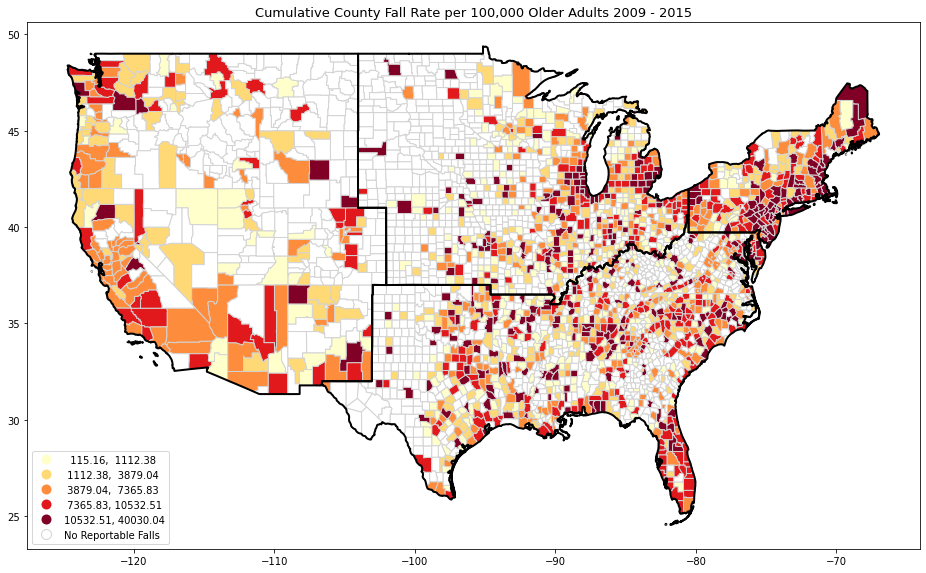

In [265]:
#plot 
# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color sheme:

missing_kwds={"color": "white",
"edgecolor": "lightgrey",
"label": "No Reportable Falls"}

plot_data.plot(column='scaled_cum_rate', scheme='Quantiles', k= 5,
         legend=True, edgecolor = 'lightgrey', cmap = 'YlOrRd',
               legend_kwds=dict(loc='lower left'),
         missing_kwds=missing_kwds, ax=ax)

plot_data.loc[plot_data['region_full'] == 'west'].dissolve('region_full').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plot_data.loc[plot_data['region_full'] == 'midwest'].dissolve('region_full').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plot_data.loc[plot_data['region_full'] == 'south'].dissolve('region_full').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plot_data.loc[plot_data['region_full'] == 'northeast'].dissolve('region_full').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

ax.set_title('Cumulative County Fall Rate per 100,000 Older Adults 2009 - 2015', fontsize=13)
plt.savefig('National_cum_fall_rates.png');


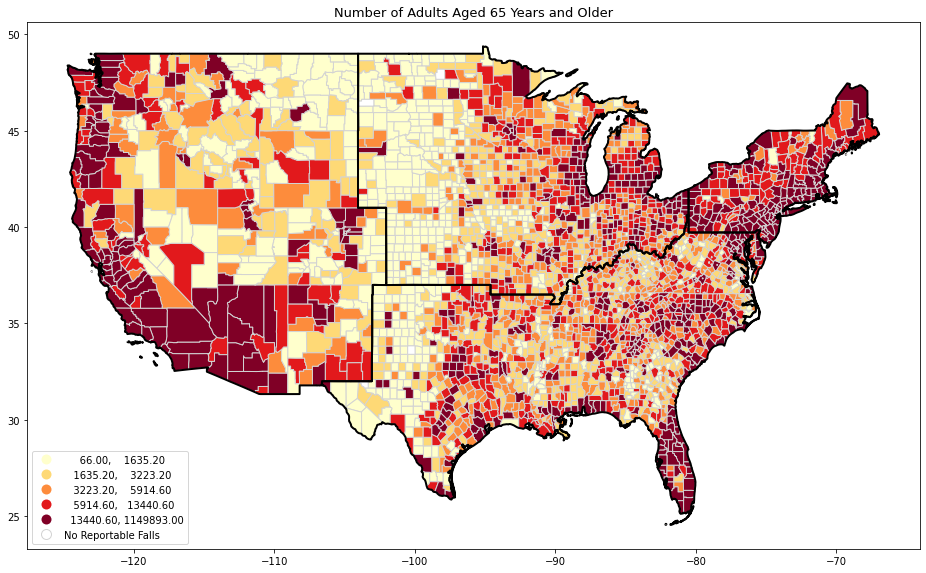

In [189]:
#Population Plot 

# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color sheme:

plot_data.plot(column='pop_65_up', scheme='Quantiles', k= 5,
         legend=True, edgecolor = 'lightgrey', cmap = 'YlOrRd',
               legend_kwds=dict(loc='lower left'),
               missing_kwds=missing_kwds, ax=ax)
         

plot_data.loc[plot_data['region_full'] == 'west'].dissolve('region_full').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plot_data.loc[plot_data['region_full'] == 'midwest'].dissolve('region_full').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plot_data.loc[plot_data['region_full'] == 'south'].dissolve('region_full').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
plot_data.loc[plot_data['region_full'] == 'northeast'].dissolve('region_full').plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

ax.set_title('Number of Adults Aged 65 Years and Older', fontsize=13);


## Now we will use the non-missing data to look at national fall rate patterns by time

In [191]:
total_month_falls = no_missing[['month_count', 'date']].groupby(['date'] ).sum().reset_index()

In [192]:
total_month_falls.head()

,date,month_count
0,2009-07,42750.0
1,2009-08,40931.0
2,2009-09,40595.0
3,2009-10,42318.0
4,2009-11,40727.0


In [202]:
np.nansum(county_pops['pop_65_up'])

42902999.0

In [198]:
(42750.0/ 2494925218.0) * 100000

1.7134782113537481

In [203]:
total_month_falls['national_fall_rate'] = (total_month_falls['month_count'] / np.nansum(county_pops['pop_65_up']))  * 100000

In [204]:
total_month_falls.head()

,date,month_count,national_fall_rate
0,2009-07,42750.0,99.643384
1,2009-08,40931.0,95.403587
2,2009-09,40595.0,94.620425
3,2009-10,42318.0,98.636461
4,2009-11,40727.0,94.928096


In [205]:
total_month_falls['date'] = pd.to_datetime(total_month_falls['date'])

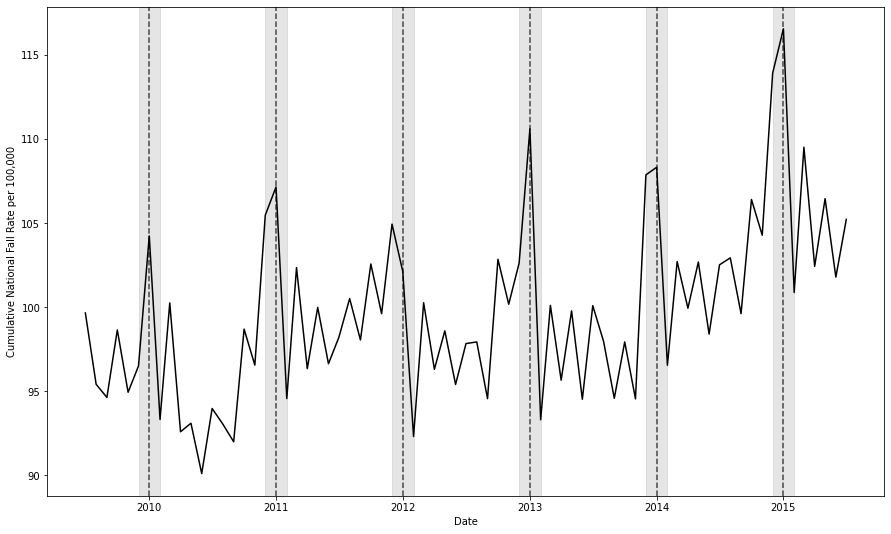

In [266]:
#this sums all the fall rates 
#to create total country-wide fall rates might need to calculate this differently 
import datetime as dt
fig, ax = plt.subplots(figsize = (15, 9))
ax.plot(total_month_falls['date'], total_month_falls['national_fall_rate'], color = 'black')
ax.set(xlabel = 'Date', ylabel = 'Cumulative National Fall Rate per 100,000')

#january lines
ax.axvline(dt.datetime(2010, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
ax.axvline(dt.datetime(2011, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
ax.axvline(dt.datetime(2012, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
ax.axvline(dt.datetime(2013, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
ax.axvline(dt.datetime(2014, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
ax.axvline(dt.datetime(2015, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)

#winter shading
ax.axvspan(dt.datetime(2009, 12, 1),dt.datetime(2010, 2, 1),color = 'gray', alpha = .2, zorder = -1)
ax.axvspan(dt.datetime(2010, 12, 1),dt.datetime(2011, 2, 1),color = 'gray', alpha = .2, zorder = -1)
ax.axvspan(dt.datetime(2011, 12, 1),dt.datetime(2012, 2, 1),color = 'gray', alpha = .2, zorder = -1)
ax.axvspan(dt.datetime(2012, 12, 1),dt.datetime(2013, 2, 1),color = 'gray', alpha = .2, zorder = -1)
ax.axvspan(dt.datetime(2013, 12, 1),dt.datetime(2014, 2, 1),color = 'gray', alpha = .2, zorder = -1)
ax.axvspan(dt.datetime(2014, 12, 1),dt.datetime(2015, 2, 1),color = 'gray', alpha = .2, zorder = -1)

plt.savefig('National_seasonal_pattern.png');


In [223]:
#now recreate this by region 
region_total_month_falls = no_missing[['month_count', 'date', 'region']].groupby(['region', 'date'] ).sum().reset_index()
region_total_month_falls.head()

,region,date,month_count
0,midwest,2009-07,10068.0
1,midwest,2009-08,9535.0
2,midwest,2009-09,9453.0
3,midwest,2009-10,9612.0
4,midwest,2009-11,9176.0


In [230]:
midwest_total_months = region_total_month_falls[region_total_month_falls['region'] == 'midwest']
midwest_total_months['midwest_fall_rate'] = (midwest_total_months['month_count'] / np.nansum(county_pops[county_pops['region'] == 'midwest']['pop_65_up']))  * 100000
midwest_total_months['date'] = pd.to_datetime(midwest_total_months['date'])


/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_83852/722492309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  midwest_total_months['midwest_fall_rate'] = (midwest_total_months['month_count'] / np.nansum(county_pops[county_pops['region'] == 'midwest']['pop_65_up']))  * 100000
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_83852/722492309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  midwest_total_months['date'] = pd.to_datetime(midwest_total_months['date'])


In [231]:
west_total_months = region_total_month_falls[region_total_month_falls['region'] == 'west']
west_total_months['west_fall_rate'] = (west_total_months['month_count'] / np.nansum(county_pops[county_pops['region'] == 'west']['pop_65_up']))  * 100000
west_total_months['date'] = pd.to_datetime(west_total_months['date'])


/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_83852/4176872712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  west_total_months['west_fall_rate'] = (west_total_months['month_count'] / np.nansum(county_pops[county_pops['region'] == 'west']['pop_65_up']))  * 100000
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_83852/4176872712.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  west_total_months['date'] = pd.to_datetime(west_total_months['date'])


In [237]:
northeast_total_months = region_total_month_falls[region_total_month_falls['region'] == 'northeast']
northeast_total_months['northeast_fall_rate'] = (northeast_total_months['month_count'] / np.nansum(county_pops[county_pops['region'] == 'northeast']['pop_65_up']))  * 100000
northeast_total_months['date'] = pd.to_datetime(northeast_total_months['date'])


/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_83852/825693224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  northeast_total_months['northeast_fall_rate'] = (northeast_total_months['month_count'] / np.nansum(county_pops[county_pops['region'] == 'northeast']['pop_65_up']))  * 100000
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_83852/825693224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  northeast_total_months['date'] = pd.to_datetime(northeast_total_months['date'])


In [235]:
south_total_months = region_total_month_falls[region_total_month_falls['region'] == 'south']
south_total_months['south_fall_rate'] = (south_total_months['month_count'] / np.nansum(county_pops[county_pops['region'] == 'south']['pop_65_up']))  * 100000
south_total_months['date'] = pd.to_datetime(south_total_months['date'])


/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_83852/2024900232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  south_total_months['south_fall_rate'] = (south_total_months['month_count'] / np.nansum(county_pops[county_pops['region'] == 'south']['pop_65_up']))  * 100000
/var/folders/gy/w5ghr6zn5jn84fzh3qwwsnbm0000gn/T/ipykernel_83852/2024900232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  south_total_months['date'] = pd.to_datetime(south_total_months['date'])


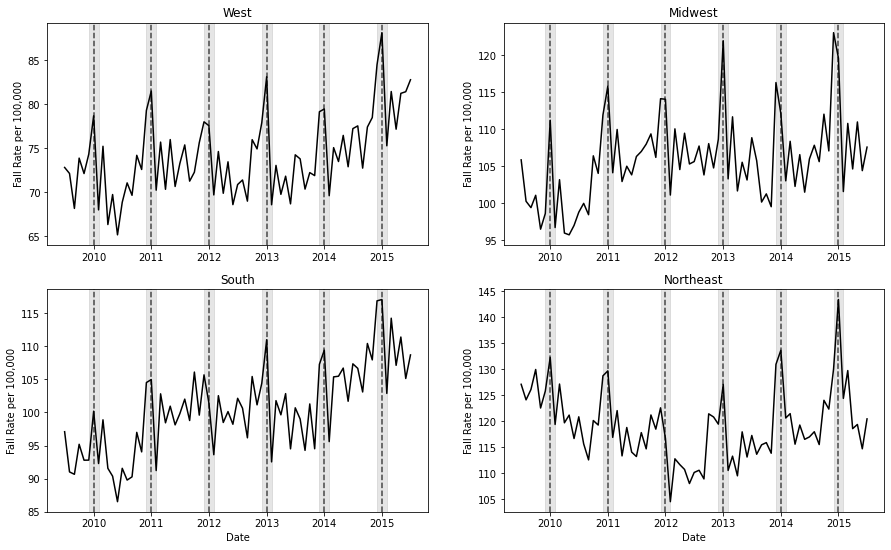

In [268]:
fig, ax = plt.subplots(2, 2, figsize = (15, 9))

ax[0,0].plot(west_total_months['date'], west_total_months['west_fall_rate'], color = 'black')
ax[0,0].set(ylabel = 'Fall Rate per 100,000', title = 'West')


ax[0,1].plot(midwest_total_months['date'], midwest_total_months['midwest_fall_rate'], color = 'black')
ax[0,1].set(ylabel = 'Fall Rate per 100,000', title = 'Midwest')

ax[1,0].plot(south_total_months['date'], south_total_months['south_fall_rate'], color = 'black')
ax[1,0].set(xlabel = 'Date', ylabel = 'Fall Rate per 100,000', title = 'South')

ax[1,1].plot(northeast_total_months['date'], northeast_total_months['northeast_fall_rate'], color = 'black')
ax[1,1].set(xlabel = 'Date', ylabel = 'Fall Rate per 100,000', title = 'Northeast')


for i in range(2):
    for j in range(2): 
        #january lines
        ax[i,j].axvline(dt.datetime(2010, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
        ax[i,j].axvline(dt.datetime(2011, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
        ax[i,j].axvline(dt.datetime(2012, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
        ax[i,j].axvline(dt.datetime(2013, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
        ax[i,j].axvline(dt.datetime(2014, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)
        ax[i,j].axvline(dt.datetime(2015, 1, 1), linestyle = '--', color = 'black', alpha = 0.7)

        #winter shading
        ax[i,j].axvspan(dt.datetime(2009, 12, 1),dt.datetime(2010, 2, 1),color = 'gray', alpha = .2, zorder = -1)
        ax[i,j].axvspan(dt.datetime(2010, 12, 1),dt.datetime(2011, 2, 1),color = 'gray', alpha = .2, zorder = -1)
        ax[i,j].axvspan(dt.datetime(2011, 12, 1),dt.datetime(2012, 2, 1),color = 'gray', alpha = .2, zorder = -1)
        ax[i,j].axvspan(dt.datetime(2012, 12, 1),dt.datetime(2013, 2, 1),color = 'gray', alpha = .2, zorder = -1)
        ax[i,j].axvspan(dt.datetime(2013, 12, 1),dt.datetime(2014, 2, 1),color = 'gray', alpha = .2, zorder = -1)
        ax[i,j].axvspan(dt.datetime(2014, 12, 1),dt.datetime(2015, 2, 1),color = 'gray', alpha = .2, zorder = -1)

plt.savefig('Regional_cum_fall_rates.png');


In [269]:
#use county pops so no repeats 
county_pops[county_pops['pop_65_up']== max(county_pops['pop_65_up'])]
#LA county is the largest 

,fipscounty,pop_65_up,region
175,6037.0,1149893.0,west


In [270]:
county_pops['pop_65_up'].describe()

count    3.104000e+03
mean     1.382184e+04
std      3.934436e+04
min      6.600000e+01
25%      1.973750e+03
50%      4.217000e+03
75%      1.056450e+04
max      1.149893e+06
Name: pop_65_up, dtype: float64

In [273]:
len(county_pops[county_pops['pop_65_up'] > 50000]) / len(county_pops)

0.05795235028976175

In [321]:
#from prior analysis
#create an indicator of those counties missing fall data for the full period 
cum_fall_rates['nofalldata'] = np.where(cum_fall_rates['month_count']== 0.0, 1, 0)
cum_fall_rates.head()


,fipscounty,month_count,pop_65_up,scaled_cum_rate,nofalldata
0,1001,299.0,7321,4084.141511,0
1,1003,2438.0,33782,7216.861050,0
2,1005,0.0,4180,0.000000,1
3,1007,0.0,3209,0.000000,1
4,1009,60.0,9172,654.164850,0


In [325]:
cum_fall_rates['pop_65_up'].groupby(cum_fall_rates['nofalldata']).describe()


,count,mean,std,min,25%,50%,75%,max
nofalldata,,,,,,,,
0,1775.0,22683.519437,50228.040792,926.0,5276.5,8828.0,19277.5,1149893.0
1,1329.0,1986.269375,1308.432601,66.0,1022.0,1743.0,2746.0,15222.0


In [762]:
#only want sociodemographics from unique counties (use ACS)
#then merge with cum_fall_rates 
acs = pd.read_csv('final_ACS_vars.csv', index_col = 0)
acs.head()

,GEOID,total_pop,median_income,gini_index,pop_65_up,prop_65_85_up,prop_female,prop_white_nh,prop_poor
1,1001,3828,26728.0,0.4100,7321,0.091381,0.577244,0.829531,0.067614
2,1003,10881,25349.0,0.4517,33782,0.104790,0.536025,0.928453,0.065449
3,1005,3138,16750.0,0.4608,4180,0.112440,0.569139,0.652392,0.150239
4,1007,1687,19545.0,0.4365,3209,0.101901,0.550016,0.831100,0.109691
5,1009,5106,23858.0,0.4134,9172,0.087767,0.554514,0.960423,0.092673


In [773]:
missing_descriptive = acs.merge(cum_fall_rates, left_on = 'GEOID', right_on = 'fipscounty', how = 'outer') 
missing_descriptive.head()

,GEOID,total_pop,median_income,gini_index,pop_65_up_x,prop_65_85_up,prop_female,prop_white_nh,prop_poor,fipscounty,month_count,pop_65_up_y,scaled_cum_rate,nofalldata
0,1001,3828,26728.0,0.4100,7321,0.091381,0.577244,0.829531,0.067614,1001.0,299.0,7321.0,4084.141511,NaN
1,1003,10881,25349.0,0.4517,33782,0.104790,0.536025,0.928453,0.065449,1003.0,2438.0,33782.0,7216.861050,NaN
2,1005,3138,16750.0,0.4608,4180,0.112440,0.569139,0.652392,0.150239,1005.0,NaN,4180.0,NaN,1.0
3,1007,1687,19545.0,0.4365,3209,0.101901,0.550016,0.831100,0.109691,1007.0,NaN,3209.0,NaN,1.0
4,1009,5106,23858.0,0.4134,9172,0.087767,0.554514,0.960423,0.092673,1009.0,60.0,9172.0,654.164850,NaN


In [774]:
missing_descriptive["nofalldata"].fillna(0.0, inplace = True) 

In [775]:
missing_descriptive.head()

,GEOID,total_pop,median_income,gini_index,pop_65_up_x,prop_65_85_up,prop_female,prop_white_nh,prop_poor,fipscounty,month_count,pop_65_up_y,scaled_cum_rate,nofalldata
0,1001,3828,26728.0,0.4100,7321,0.091381,0.577244,0.829531,0.067614,1001.0,299.0,7321.0,4084.141511,0.0
1,1003,10881,25349.0,0.4517,33782,0.104790,0.536025,0.928453,0.065449,1003.0,2438.0,33782.0,7216.861050,0.0
2,1005,3138,16750.0,0.4608,4180,0.112440,0.569139,0.652392,0.150239,1005.0,NaN,4180.0,NaN,1.0
3,1007,1687,19545.0,0.4365,3209,0.101901,0.550016,0.831100,0.109691,1007.0,NaN,3209.0,NaN,1.0
4,1009,5106,23858.0,0.4134,9172,0.087767,0.554514,0.960423,0.092673,1009.0,60.0,9172.0,654.164850,0.0


In [788]:
missing_descriptive['prop_white_nh'].groupby(missing_descriptive['nofalldata']).describe()


,count,mean,std,min,25%,50%,75%,max
nofalldata,,,,,,,,
0.0,1891.0,0.829927,0.226812,0.000000,0.788135,0.919765,0.968773,1.0
1.0,1329.0,0.881068,0.162081,0.085876,0.832936,0.960317,0.983548,1.0
